In [1]:
# Device

import torch

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU is available and will be used.")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")

GPU is available and will be used.


In [2]:
#Imports

import os
import json
import random
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import (
    BertTokenizer, BertConfig, BertForMaskedLM, DataCollatorForLanguageModeling,
    TapasTokenizer, TapasForMaskedLM,
    AdamW, get_scheduler
)
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from model_complete import JSONBERT_COMPLETE
from dataset import JSONDataset, create_data

import sys
sys.path.append('/root/woojun/')

from utils import (
    _serialize_vanilla,
    _serialize,
    tokenize_table,
    _find_positions,
    mask_entry,
    predict_masked_tokens,
    evaluate_masked_prediction,
    train_eval_rf
)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is available and will be used.


In [3]:
# Tokenizer & config

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
config = BertConfig.from_pretrained('bert-base-uncased')

In [4]:
# Models

# BERT
bert_base = BertForMaskedLM.from_pretrained('bert-base-uncased')
bert_base = bert_base.to(device)

# TaPas
tapas_name = "google/tapas-base-masklm"
tapas_tokenizer = TapasTokenizer.from_pretrained(tapas_name)
tapas = TapasForMaskedLM.from_pretrained(tapas_name)
tapas.to(device)

# Ours
ours_path_movie = './models/movie_complete/epoch-9'
ours_movie = JSONBERT_COMPLETE(config, tokenizer, ours_path_movie)
ours_movie = ours_movie.to(device)

ours_path_movie_prev = './models/movie_complete_prev/epoch-9'
ours_movie_prev = JSONBERT_COMPLETE(config, tokenizer, ours_path_movie)
ours_movie_prev = ours_movie_prev.to(device)

ours_path_product = './models/product_complete/epoch-9'
ours_product = JSONBERT_COMPLETE(config, tokenizer, ours_path_product)
ours_product = ours_product.to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Key embeddings are trainable!
Pre-trained JSONBERT loaded from ./models/movie_complete/epoch-9
Key embeddings are trainable!
Pre-trained JSONBERT loaded from ./models/movie_complete/epoch-9
Key embeddings are trainable!
Pre-trained JSONBERT loaded from ./models/product_complete/epoch-9


In [27]:
# BERT
bert_movie = BertForMaskedLM.from_pretrained('./models/movie_bert_prev/epoch-9', local_files_only=True)
bert_movie = bert_movie.to(device)

### Preprocessing

In [5]:
np.__version__

'1.26.4'

In [6]:
# Movie

pretraining_movie_path = './data/pretraining_data_movie.jsonl'
movie_path = './data/Movie_top100'
movie_json = create_data(movie_path, path_is="test", sample_num=20, pretraining_path=pretraining_movie_path)

Skipping non-English table: Movie_adorocinema.com_October2023.json
Skipping non-English table: Movie_afisha.ru_October2023.json
Skipping non-English table: Movie_ak.sv_October2023.json
Skipping non-English table: Movie_allcinema.net_October2023.json
Skipping non-English table: Movie_allocine.fr_October2023.json
Skipping non-English table: Movie_arte.tv_October2023.json
Skipping non-English table: Movie_cinecitta.de_October2023.json
Skipping non-English table: Movie_cinefil.com_October2023.json
Skipping non-English table: Movie_cinema-rank.net_October2023.json
Skipping non-English table: Movie_cinematoday.jp_October2023.json
Skipping non-English table: Movie_comingsoon.it_October2023.json
Skipping non-English table: Movie_cpop.it_October2023.json
Skipping non-English table: Movie_crank-in.net_October2023.json
Skipping non-English table: Movie_dok-film.net_October2023.json
Skipping non-English table: Movie_domkino.tv_October2023.json
Skipping non-English table: Movie_ecranlarge.com_Octob

In [7]:
len(movie_json)

1020

In [8]:
# Product
pretraining_product_path = './data/pretraining_data_product.jsonl'
product_path = './data/Product_top100'
product_json = create_data(product_path, path_is="test", sample_num=20, pretraining_path=pretraining_product_path)

Skipping non-English table: Product_10x10.co.kr_October2023.json
Skipping non-English table: Product_all.biz_October2023.json
Skipping non-English table: Product_avito.ru_October2023.json
Skipping non-English table: Product_com.ru_October2023.json
Skipping non-English table: Product_docomo.ne.jp_October2023.json
Skipping non-English table: Product_elektronikai-hulladek-felvasarlas.hu_October2023.json
Skipping non-English table: Product_eltiempo.com_October2023.json
Skipping non-English table: Product_fateful.hu_October2023.json
Skipping non-English table: Product_havidijas-keresooptimalizalas.hu_October2023.json
Skipping non-English table: Product_iherb.com_October2023.json
Skipping non-English table: Product_line.me_October2023.json
Skipping non-English table: Product_lookfantastic.com_October2023.json
Skipping non-English table: Product_mattel.com_October2023.json
Skipping non-English table: Product_numizmatik.ru_October2023.json
Skipping non-English table: Product_odoo.com_October20

In [9]:
len(product_json)

1320

In [10]:
movie_df =  pd.DataFrame(movie_json)
product_df = pd.DataFrame(product_json)

In [11]:
half_index = len(movie_df) // 2
E1_movie = movie_df.iloc[:half_index]
E2_movie = movie_df.iloc[half_index:]

columns_to_drop = ['name', 'description', 'page_url']
E1_corrupted_movie = E1_movie.drop(columns=columns_to_drop)
E1_corrupted_movie = E1_corrupted_movie[sorted(E1_corrupted_movie.columns)]

In [12]:
half_index = len(product_df) // 2
E1_product = product_df.iloc[:half_index]
E2_product = product_df.iloc[half_index:]

columns_to_drop = ['name', 'url', 'image']
E1_corrupted_product = E1_product.drop(columns=columns_to_drop)
E1_corrupted_product = E1_corrupted_product[sorted(E1_corrupted_product.columns)]

Extracted Unseen columns

In [25]:
import matplotlib.pyplot as plt
from scipy.stats import entropy

def get_embedding(entry, model, tokenizer):
    inputs, _ = tokenize_table(entry, tokenizer)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True) 

    if hasattr(model, "key_embedding"):
        last_hidden_state = outputs["hidden_states"][-1]
    else:
        last_hidden_state = outputs.hidden_states[-1]

    embedding = last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return embedding


def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def entity_matching(E1, E2, E1_prime, model, tokenizer):
    # Calculate similarity distributions
    E1_list = E1.to_dict(orient="records")
    E2_list = E2.to_dict(orient="records")
    E1_prime_list = E1_prime.to_dict(orient="records")

    E1_embeddings = np.array([get_embedding(row, model, tokenizer) for row in E1_list])
    E2_embeddings = np.array([get_embedding(row, model, tokenizer) for row in E2_list])
    E1_prime_embeddings = np.array([get_embedding(row, model, tokenizer) for row in E1_prime_list])

    sim_E1_E2 = np.array([cosine_similarity(e1, e2) for e1 in E1_embeddings for e2 in E2_embeddings])
    sim_E1_E1_prime = np.array([cosine_similarity(e1, e1p) for e1, e1p in zip(E1_embeddings, E1_prime_embeddings)])

    # Calculate distribution overlap
    overlap = np.sum(np.minimum(np.histogram(sim_E1_E2, bins=50, density=True)[0], 
                                np.histogram(sim_E1_E1_prime, bins=50, density=True)[0]))

    # Calculate KL divergence
    hist1 = np.histogram(sim_E1_E2, bins=50, density=True)[0]
    hist2 = np.histogram(sim_E1_E1_prime, bins=50, density=True)[0]
    kl_div = entropy(hist1 + 1e-10, hist2 + 1e-10)

    # Plot the distributions
    plt.figure(figsize=(10, 6))

    plt.hist(sim_E1_E2, bins=50, alpha=0.5, label='Sim(E1, E2)', color='blue', density=True)
    plt.hist(sim_E1_E1_prime, bins=50, alpha=0.5, label="Sim(E1, E1')", color='green', density=True)

    plt.title('Similarity Distributions')
    plt.xlabel('Similarity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    print(f"KL Divergence: {kl_div}")

def entity_matching2(E1, E2, E1_prime, model1, tokenizer1, model2, tokenizer2):
    # Calculate similarity distributions
    E1_list = E1.to_dict(orient="records")
    E2_list = E2.to_dict(orient="records")
    E1_prime_list = E1_prime.to_dict(orient="records")

    E1_embeddings_1 = np.array([get_embedding(row, model1, tokenizer1) for row in E1_list])
    E2_embeddings_1 = np.array([get_embedding(row, model1, tokenizer1) for row in E2_list])
    E1_prime_embeddings_1 = np.array([get_embedding(row, model1, tokenizer1) for row in E1_prime_list])

    sim_E1_E2_1 = np.array([cosine_similarity(e1, e2) for e1 in E1_embeddings_1 for e2 in E2_embeddings_1])
    # sim_E1_E1_prime_1 = np.array([cosine_similarity(e1, e1p) for e1, e1p in zip(E1_embeddings_1, E1_prime_embeddings_1)])

    E1_embeddings_2 = np.array([get_embedding(row, model2, tokenizer2) for row in E1_list])
    E2_embeddings_2 = np.array([get_embedding(row, model2, tokenizer2) for row in E2_list])
    E1_prime_embeddings_2 = np.array([get_embedding(row, model2, tokenizer2) for row in E1_prime_list])

    sim_E1_E2_2 = np.array([cosine_similarity(e1, e2) for e1 in E1_embeddings_2 for e2 in E2_embeddings_2])
    # sim_E1_E1_prime_2 = np.array([cosine_similarity(e1, e1p) for e1, e1p in zip(E1_embeddings_2, E1_prime_embeddings_2)])

    E1_embeddings_3 = np.array([get_embedding(row, model3, tokenizer3) for row in E1_list])
    E2_embeddings_3 = np.array([get_embedding(row, model3, tokenizer1) for row in E2_list])
    E1_prime_embeddings_3 = np.array([get_embedding(row, model3, tokenizer3) for row in E1_prime_list])

    sim_E1_E2_3 = np.array([cosine_similarity(e1, e2) for e1 in E1_embeddings_3 for e2 in E2_embeddings_3])
    # sim_E1_E1_prime_3 = np.array([cosine_similarity(e1, e1p) for e1, e1p in zip(E1_embeddings_3, E1_prime_embeddings_3)])

    # # Calculate distribution overlap
    # overlap = np.sum(np.minimum(np.histogram(sim_E1_E2, bins=50, density=True)[0], 
    #                             np.histogram(sim_E1_E1_prime, bins=50, density=True)[0]))

    # # Calculate KL divergence
    # hist1 = np.histogram(sim_E1_E2, bins=50, density=True)[0]
    # hist2 = np.histogram(sim_E1_E1_prime, bins=50, density=True)[0]
    # kl_div = entropy(hist1 + 1e-10, hist2 + 1e-10)

    # Plot the distributions
    plt.figure(figsize=(10, 6))

    plt.hist(sim_E1_E2_1, bins=50, alpha=0.5, label='Sim(E1, E2)', color='green', density=True)
    plt.hist(sim_E1_E2_2, bins=50, alpha=0.5, label='Sim(E1, E2)', color='blue', density=True)
    # plt.hist(sim_E1_E2_3, bins=50, alpha=0.5, label='Sim(E1, E2)', color='red', density=True)
    # plt.hist(sim_E1_E1_prime, bins=50, alpha=0.5, label="Sim(E1, E1')", color='green', density=True)

    plt.title('Similarity Distributions')
    plt.xlabel('Similarity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    print(f"KL Divergence: {kl_div}")


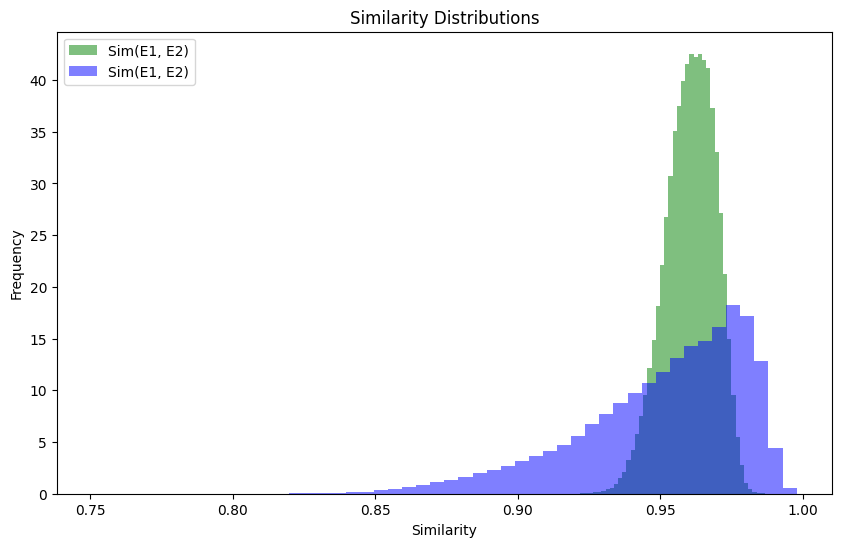

NameError: name 'kl_div' is not defined

In [26]:
entity_matching2(E1_movie, E2_movie, E1_corrupted_movie, ours_movie, tokenizer, bert_base, tokenizer)

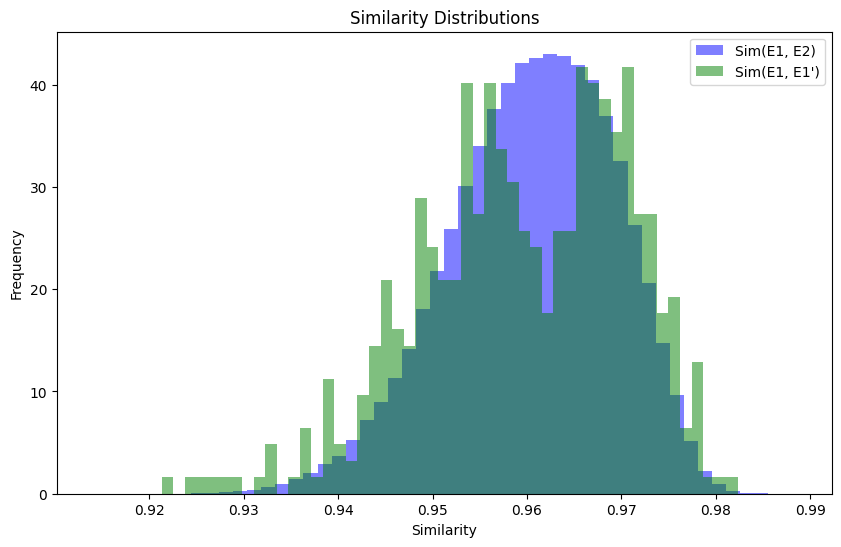

KL Divergence: 0.24542527062862476


In [14]:
entity_matching(E1_movie, E2_movie, E1_corrupted_movie, ours_movie, tokenizer)

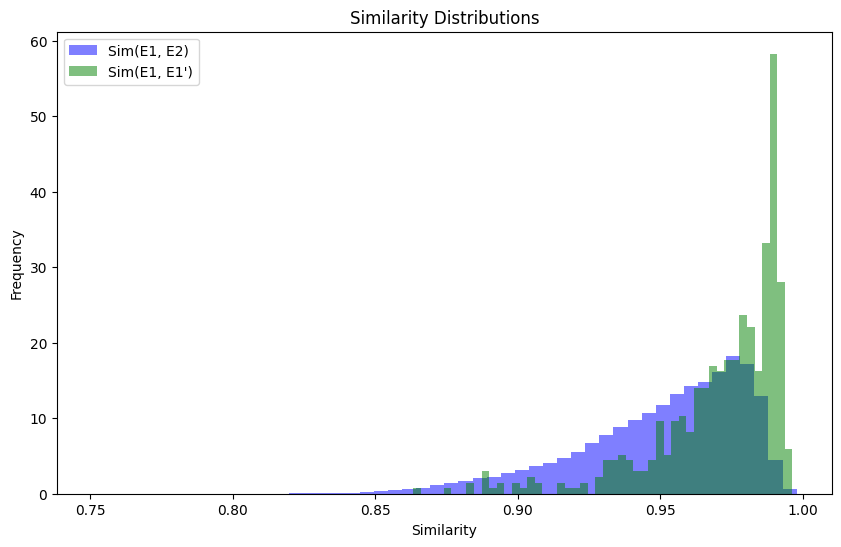

KL Divergence: 0.274961047866502


In [15]:
entity_matching(E1_movie, E2_movie, E1_corrupted_movie, bert_base, tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/models/tapas/tokenization_tapas.py:2699: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/usr/local/lib/python3.10/dist-packages/transformers/models/tapas/tokenization_tapas.py:1493: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]


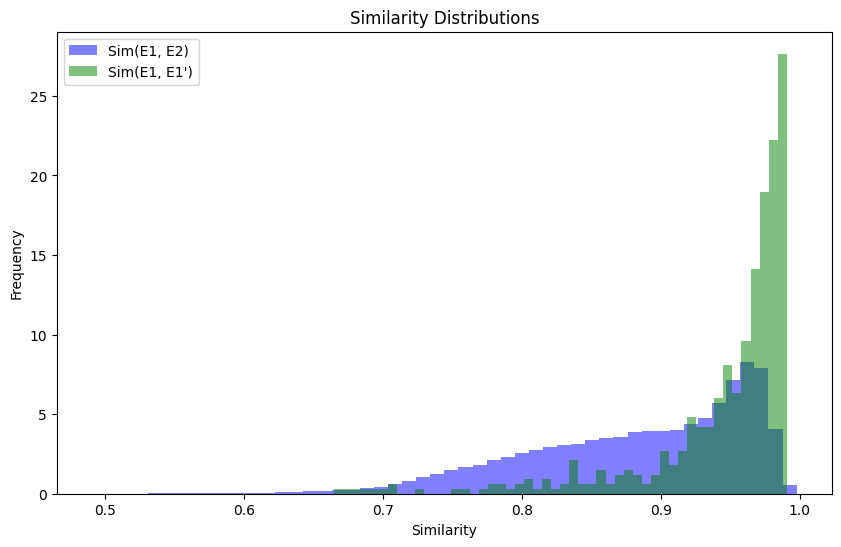

KL Divergence: 0.5601512978452039


In [16]:
entity_matching(E1_movie, E2_movie, E1_corrupted_movie, tapas, tapas_tokenizer)

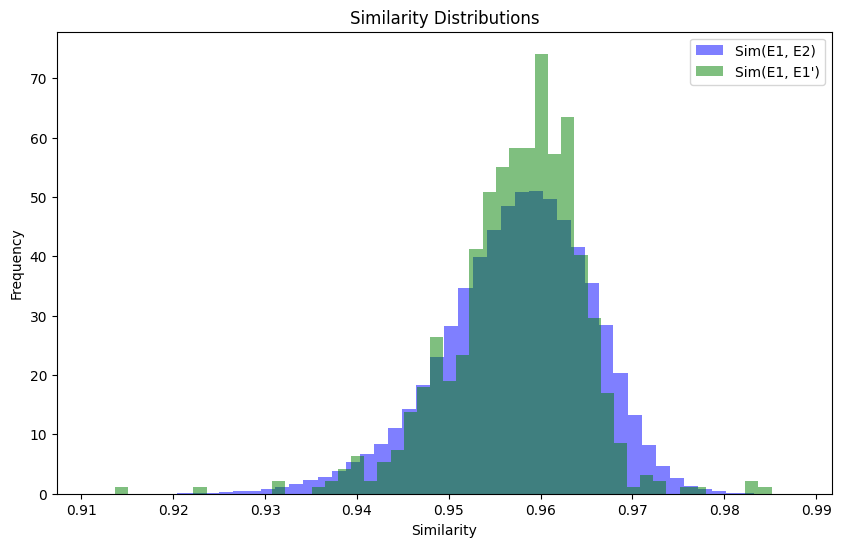

KL Divergence: 0.2563397476674415


In [17]:
entity_matching(E1_product, E2_product, E1_corrupted_product, ours_product, tokenizer)

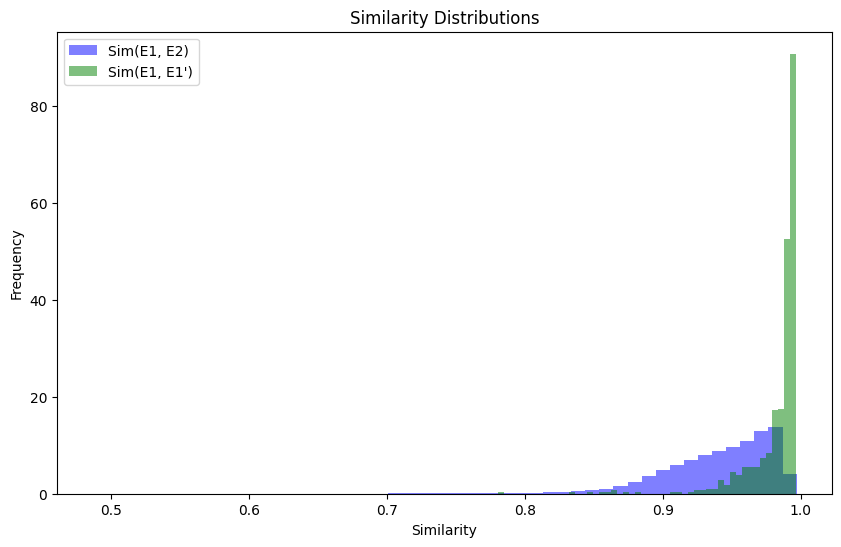

KL Divergence: 0.7167957902562238


In [18]:
entity_matching(E1_product, E2_product, E1_corrupted_product, bert_base, tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/models/tapas/tokenization_tapas.py:2699: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/usr/local/lib/python3.10/dist-packages/transformers/models/tapas/tokenization_tapas.py:1493: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]


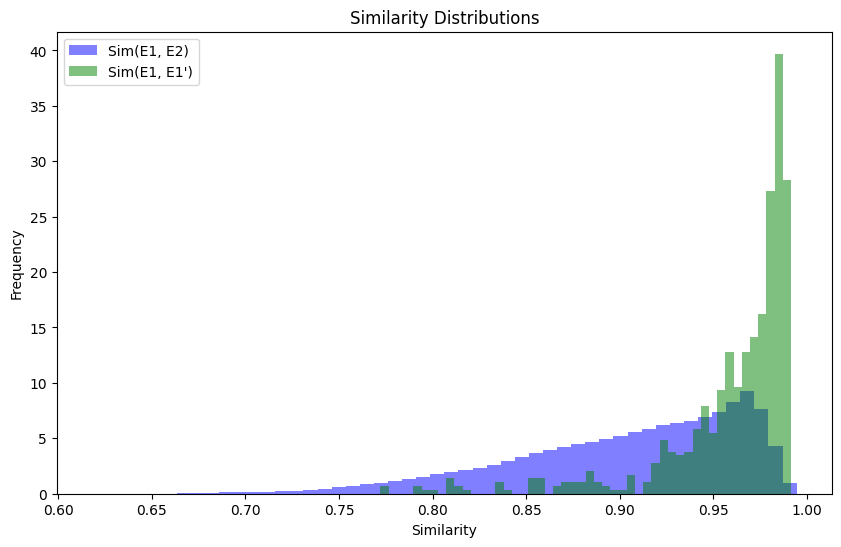

KL Divergence: 1.5348920904600714


In [19]:
entity_matching(E1_product, E2_product, E1_corrupted_product, tapas, tapas_tokenizer)